# Prepare the CHIME data

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pandas as pd

dt 0.9830399940256029
times (192,)
cal_ts (192,)


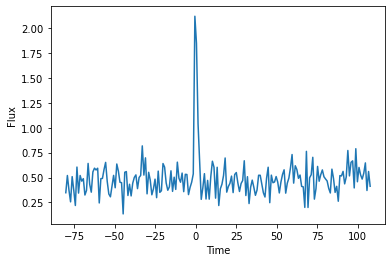

dt 0.9830399940256029
times (192,)
cal_ts (192,)


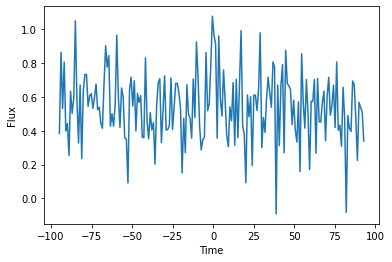

dt 0.9830399649217725
times (192,)
cal_ts (192,)


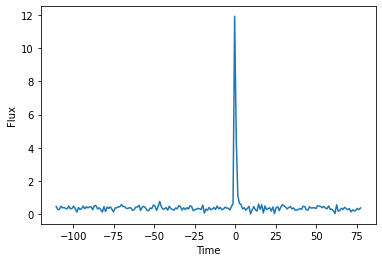

In [2]:
# Visualize all lightcurves
for file_name in glob.glob("/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/*.h5"):
    data = h5py.File(file_name, "r")

    plot_time = data["frb"]["plot_time"][:]
    ts = data["frb"]["ts"][:]
    cal_wfall =  data["frb"]["calibrated_wfall"][:]
    dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
    
    print('dt', dt)
    
    peak_idx = np.argmax(ts)  # ts from wfall
    cal_ts = np.nanmean(cal_wfall, axis = 0) #flattening the calibrated wfall ?? 
    cal_wfall[np.isnan(cal_wfall)] = np.nanmedian(cal_wfall)   # replace nans in the data with the data median
    times = np.arange(len(cal_ts))*dt 
    peak_idx = np.argmax(cal_ts)
    times -= times[peak_idx]
    times -= dt / 2.
    print('times', times.shape)
    print('cal_ts', cal_ts.shape)
    plt.plot(times, cal_ts)
    plt.xlabel('Time (ms)')
    plt.ylabel('Flux (Jy)')
    plt.show()

# Filter CHIME catalog

In [8]:
from cfod import catalog 

# Get the complete CHIME/FRB catalog 
catalog = catalog.as_dataframe()
print(f"The columns of the CHIME/FRB catalog:\n {catalog.columns}")
# Filter the catalog keeping only the FRBs that have unmeasurable scattering 
filtered_cat = catalog[catalog['scat_time'].str.contains('<')]
# get max boxcarwidth in catalog 
max_bc_width = max(filtered_cat['bc_width'])

The columns of the CHIME/FRB catalog:
 Index(['tns_name', 'previous_name', 'repeater_name', 'ra', 'ra_err',
       'ra_notes', 'dec', 'dec_err', 'dec_notes', 'gl', 'gb', 'exp_up',
       'exp_up_err', 'exp_up_notes', 'exp_low', 'exp_low_err', 'exp_low_notes',
       'bonsai_snr', 'bonsai_dm', 'low_ft_68', 'up_ft_68', 'low_ft_95',
       'up_ft_95', 'snr_fitb', 'dm_fitb', 'dm_fitb_err', 'dm_exc_ne2001',
       'dm_exc_ymw16', 'bc_width', 'scat_time', 'scat_time_err', 'flux',
       'flux_err', 'flux_notes', 'fluence', 'fluence_err', 'fluence_notes',
       'sub_num', 'mjd_400', 'mjd_400_err', 'mjd_inf', 'mjd_inf_err',
       'width_fitb', 'width_fitb_err', 'sp_idx', 'sp_idx_err', 'sp_run',
       'sp_run_err', 'high_freq', 'low_freq', 'peak_freq', 'excluded_flag'],
      dtype='object')


In [13]:
# Get the data based on the the filtered catalog 
data_dir = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/*.h5"
filtered_data = [file for file in glob.glob(data_dir) for frb in filtered_cat['tns_name'] if frb in file]
print(f"Filtered {len(filtered_data)} FRBs of the total of {len(catalog)} in the CHIME/FRB catalog.")

Filtered 288 FRBs of the total of 600 in the CHIME/FRB catalog.


In [14]:
def cut_noise(time, flux, max_bc_width):
    """Cut away noise in the FRB lightcurve by only keeping two boxcar widths 
    from the peak of the FRB (maximum flux in the lightcurve)."""

    # Get flux and time of the FRB peak
    idx_peak_flux = np.argmax(flux)
    peak_time = time[idx_peak_flux]

    # Standard deviation of the noise 
    flux_err = np.std(flux[(time < peak_time - 1000*max_bc_width)])
    
    # Get shortenend lightcurve keeping only one boxcar width on either side of the peak
    time_cut = time[(time > peak_time - 1000*max_bc_width) * (time < peak_time + 1000*max_bc_width)] # from seconds to milliseconds
    flux_cut = flux[(time > peak_time - 1000*max_bc_width) * (time < peak_time + 1000*max_bc_width)]

    return time_cut, flux_cut, flux_err  

In [15]:
for file in filtered_data: 
    
    try: 
        data = h5py.File(file, "r")

        # Unpack the data
        cal_wfall =  data["frb"]["calibrated_wfall"][:] # waterfall data (dynamic spectrum) with calibration applied 
        flux = np.nanmean(cal_wfall, axis = 0) # flattening the calibrated wfall to make it into a time series (flux) (cal_ts)

        plot_time = data["frb"]["plot_time"][:] # the value of the time indices in microseconds
        dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
        peak_idx = np.argmax(flux) # indice of the peak flux 
        time = np.arange(len(flux))*dt 
        time -= time[peak_idx]
        time -= dt / 2.

        # Cut away noise in the lightcurve
        time, flux, flux_err = cut_noise(time, flux, max_bc_width)

        # Convert into .dat file with columns time, flux and flux error 
        df = pd.DataFrame(time, columns=['time'])
        df['flux'] = flux 
        df['flux_err'] = flux_err  
        position = file.index('.')

        df.to_csv(file[0:position]+".dat", sep=" ", header=False, index=False) # this overwrites files with same name

    except Exception as e:
        print(f"{e} for {file}")

/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


"Unable to open object (object 'calibrated_wfall' doesn't exist)" for /mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/FRB20190307A_waterfall.h5
"Unable to open object (object 'calibrated_wfall' doesn't exist)" for /mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/FRB20190429B_waterfall.h5
"Unable to open object (object 'calibrated_wfall' doesn't exist)" for /mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/FRB20190531A_waterfall.h5
"Unable to open object (object 'calibrated_wfall' doesn't exist)" for /mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/FRB20190531B_waterfall.h5


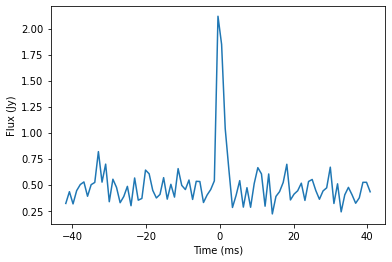

In [27]:
### Test to produce one file with std flux error and shortened lightcurve 

file = "/mnt/c/Users/Mariska Hoogkamer/Documents/UvA/FRBs/data/data_CHIME/data/FRB20180725A_waterfall.h5"

data = h5py.File(file, "r")

# Unpack the data
cal_wfall =  data["frb"]["calibrated_wfall"][:] # waterfall data (dynamic spectrum) with calibration applied 
flux = np.nanmean(cal_wfall, axis = 0) # flattening the calibrated wfall to make it into a time series (flux) (cal_ts)

plot_time = data["frb"]["plot_time"][:] # the value of the time indices in microseconds
dt = np.median(np.diff(plot_time)) # the delta (time) between time bins 
peak_idx = np.argmax(flux) # indice of the peak flux 
time = np.arange(len(flux))*dt 
time -= time[peak_idx]
time -= dt / 2.

# Cut away noise in the lightcurve
time, flux, flux_err = cut_noise(time, flux, max_bc_width)

# Convert into .dat file with columns time, flux and flux error 
df = pd.DataFrame(time, columns=['time'])
df['flux'] = flux 
df['flux_err'] = flux_err  
position = file.index('.')

df.to_csv(file[0:position]+".dat", sep=" ", header=False, index=False)

plt.plot(time, flux)
plt.xlabel('Time (ms)')
plt.ylabel('Flux (Jy)')
plt.show()

In [1]:
# If you want CHIME also in SNR, then get part of the mean and std of noise to normalize. 